<a href="https://colab.research.google.com/github/JaiRamteke/Diabetes_Prediction_Model_Optimization_and_Deployment/blob/main/Diabetes_Prediction_Model_Optimization_and_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
# --- Project Setup: Model Training & Evaluation with Visualization ---

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
!pip install scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, r2_score, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')
!pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Ensure directories exist
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('dashboard', exist_ok=True)

In [5]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "diabetes.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "uciml/pima-indians-diabetes-database",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

In [6]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


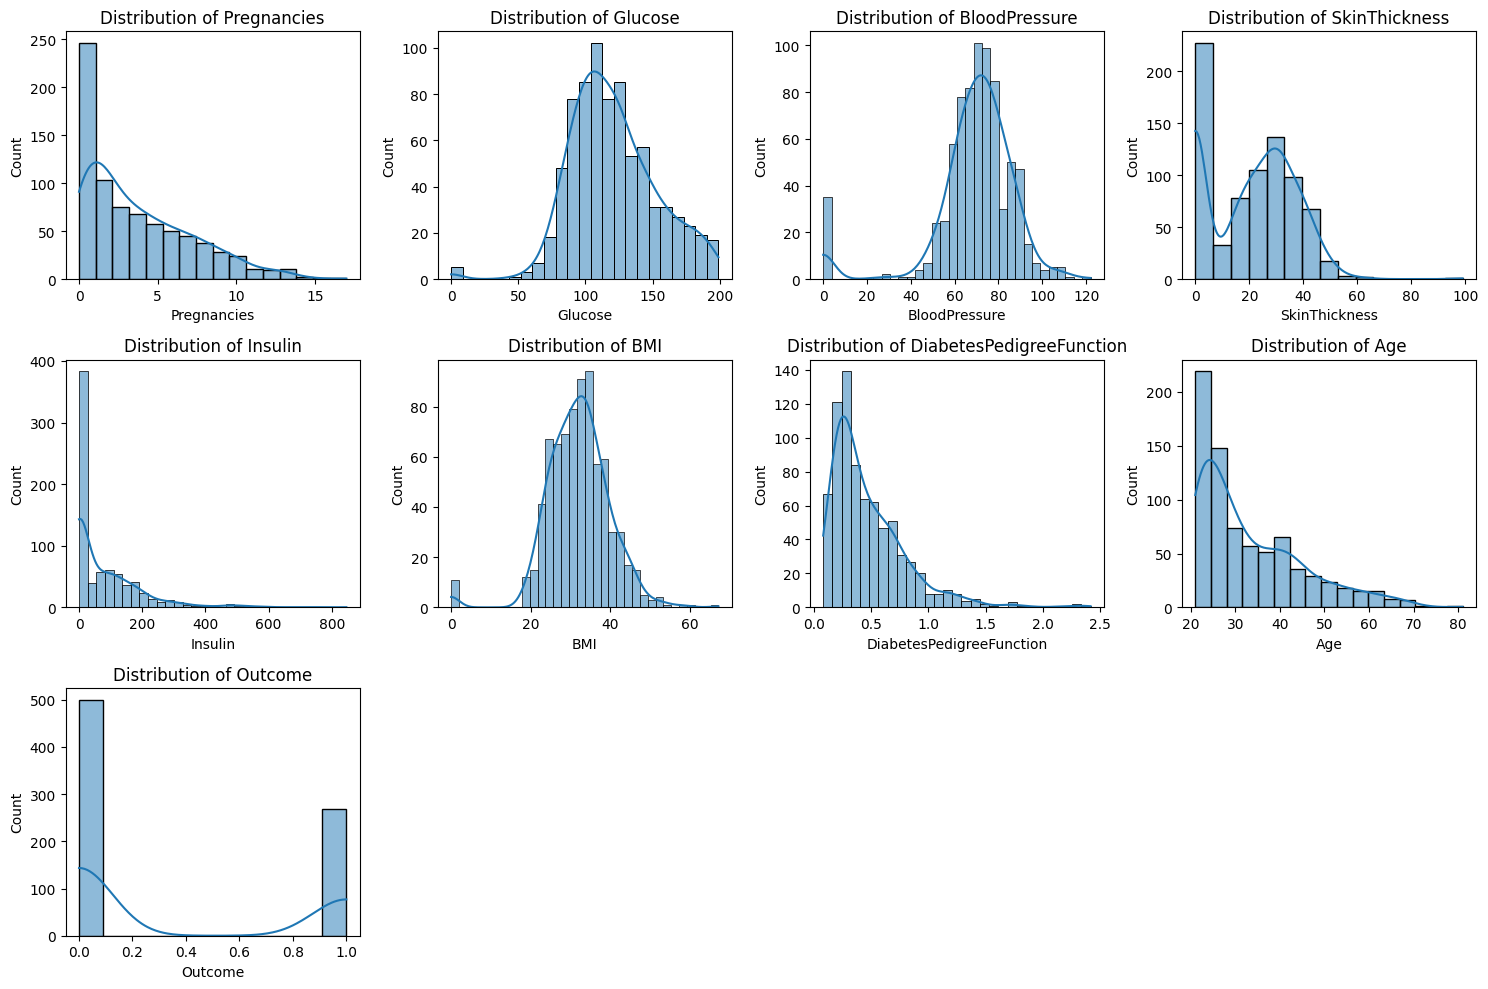

In [86]:
# ------------------ Data Preparation ------------------

# Visualize the distribution of features
plt.figure(figsize=(15, 10))
feature_names = df.columns
for i, feature in enumerate(feature_names):
    plt.subplot(3, 4, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
output_dir = 'plots'
plt.savefig(os.path.join(output_dir, 'feature_distributions.png'))

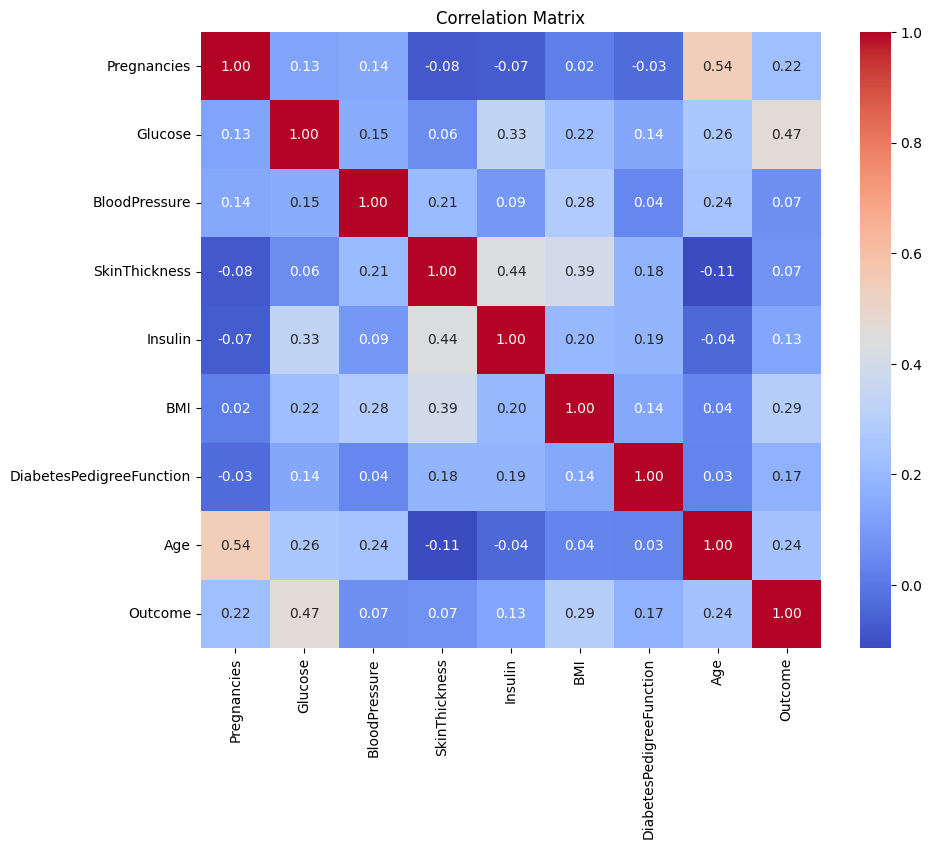

In [10]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('plots/correlation_matrix.png')
plt.show()

In [11]:
# Define target and features
target = 'Outcome'  # Change this to your actual target column name
# Replacing 'data' with 'df' since 'df' holds the DataFrame
X = df.drop(columns=[target])
y = df[target]

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Save test data for dashboard use
X_test.to_csv('dashboard/X_test.csv', index=False)
y_test.to_csv('dashboard/y_test.csv', index=False)

In [14]:
# ------------------ Model Definition ------------------

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [18]:
# Function to evaluate model
def evaluate_model(name, model, X_test, y_test, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'R2 Score': r2_score(y_test, y_pred)
    }

# Evaluate all models and store results
results = []
for name, model in models.items():
    model_results = evaluate_model(name, model, X_test, y_test, X_train, y_train)
    results.append(model_results)

# Create a pandas DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results
display(results_df)


,Model,Accuracy,Precision,Recall,F1 Score,R2 Score
0,Logistic Regression,0.746753,0.750154,0.746753,0.748167,-0.103030
1,Decision Tree,0.753247,0.760595,0.753247,0.755773,-0.074747
2,Random Forest,0.727273,0.725201,0.727273,0.726111,-0.187879
3,SVM,0.766234,0.761336,0.766234,0.758601,-0.018182
4,Gradient Boosting,0.746753,0.750154,0.746753,0.748167,-0.103030


<Figure size 1400x800 with 0 Axes>

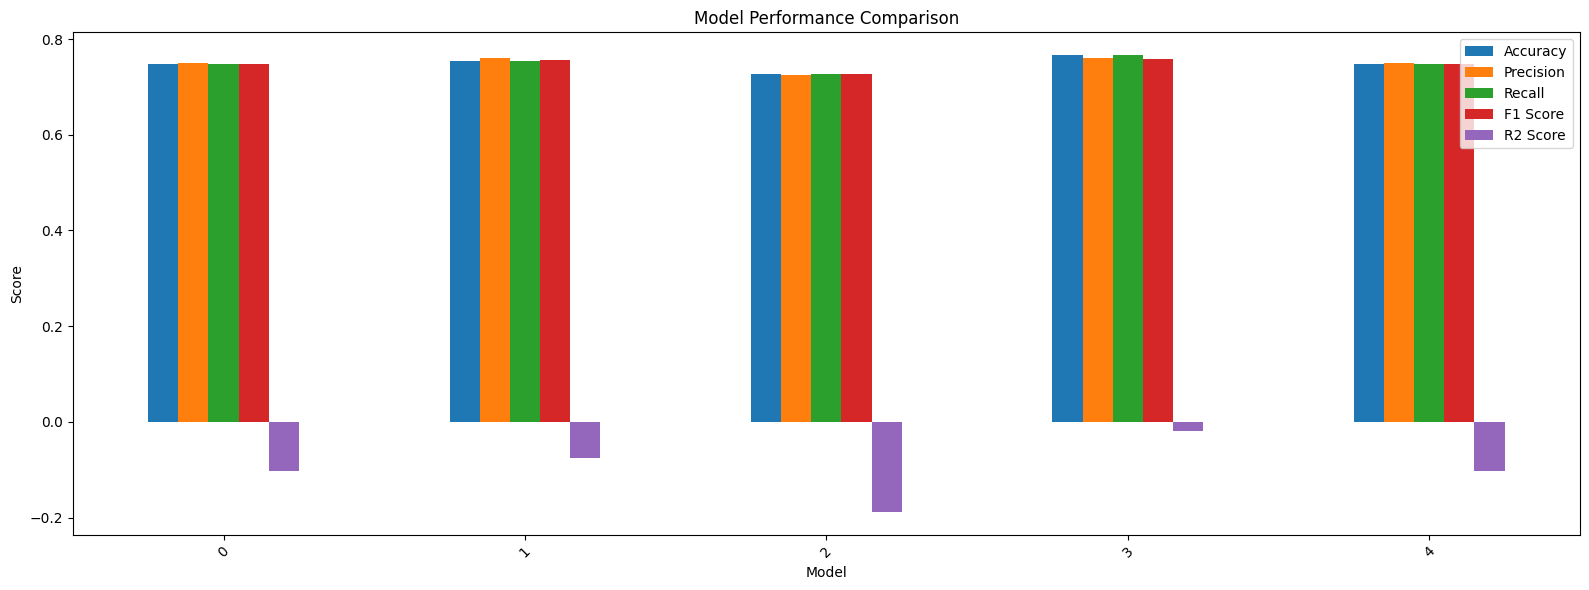

In [90]:
# Visualize model performance
plt.figure(figsize=(14, 8))
results_df.plot(kind='bar', figsize=(16, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'initial_model_performance.png'))

In [76]:
# =============================================
# 4. HYPER-PARAMETER TUNING
# =============================================

# Define a preprocessor, for example, StandardScaler:
preprocessor = StandardScaler()

# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__max_iter': [1000, 2000, 5000]
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 3, 5, 10, 15, 20, 25],
        'classifier__min_samples_split': [2, 5, 10, 15, 20],
        'classifier__min_samples_leaf': [1, 2, 4, 6, 8]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 150, 200, 250],
        'classifier__max_depth': [None, 5, 10, 15, 20, 25],
        'classifier__min_samples_split': [2, 5, 10, 15, 20],
        'classifier__min_samples_leaf': [1, 2, 4, 6, 8]
    },
    'SVM': {
        'classifier__C': [0.01, 0.1, 1, 10, ],
        'classifier__kernel': ['linear', 'rbf',],
        'classifier__gamma': ['scale', 'auto', 0.1, 1]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [25, 50, 75, 100, 125],
        'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'classifier__max_depth': [2, 3, 4, 5, 6]
    }
}

# Perform tuning
tuned_models = {}
tuning_results = {}

for name in models.keys():
    print(f"\nTuning {name}...")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', models[name])
    ])

    # Use RandomizedSearchCV for more efficient exploration
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grids[name],  # Use param_distributions
        n_iter=50,  # Number of iterations
        cv=3,
        scoring='accuracy',  # You can experiment with other scoring metrics
        n_jobs=-1,
        verbose=2,
        random_state=42  # Set random state for reproducibility
    )

    random_search.fit(X_train, y_train)
    tuned_models[name] = random_search.best_estimator_
    tuning_results[name] = random_search.best_params_

    print(f"Best parameters for {name}: {random_search.best_params_}")
    print(f"Best accuracy: {random_search.best_score_:.4f}")




Tuning Logistic Regression...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters for Logistic Regression: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__max_iter': 2000, 'classifier__C': 0.1}
Best accuracy: 0.7720

Tuning Decision Tree...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters for Decision Tree: {'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 5}
Best accuracy: 0.7639

Tuning Random Forest...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters for Random Forest: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None}
Best accuracy: 0.7817

Tuning SVM...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters for SVM: {'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__C': 1}
Best accuracy: 0.76

In [94]:
# Evaluate tuned models
def evaluate_model(model, X_test, y_test):
    """Evaluates a model and returns a dictionary of performance metrics."""

    y_pred = model.predict(X_test)

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'R2 Score': r2_score(y_test, y_pred),
        'y_pred': y_pred  # Add y_pred to the metrics dictionary
    }

    return metrics

# Evaluate original models
results = {}
for name, model in models.items():  # Using trained_models for original models
    results[name] = evaluate_model(model, X_test, y_test)

tuned_results = {}
for name, model in tuned_models.items():
    tuned_results[name] = evaluate_model(model, X_test, y_test)

tuned_results_df = pd.DataFrame(tuned_results).T
print("\nTuned Model Evaluation Results:")
display(tuned_results_df)


Tuned Model Evaluation Results:


,Accuracy,Precision,Recall,F1 Score,R2 Score,y_pred
Logistic Regression,0.75974,0.673077,0.636364,0.654206,-0.046465,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ..."
Decision Tree,0.785714,0.729167,0.636364,0.679612,0.066667,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, ..."
Random Forest,0.75974,0.660714,0.672727,0.666667,-0.046465,"[0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, ..."
SVM,0.75974,0.666667,0.654545,0.66055,-0.046465,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, ..."
Gradient Boosting,0.727273,0.610169,0.654545,0.631579,-0.187879,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, ..."


<Figure size 1400x800 with 0 Axes>

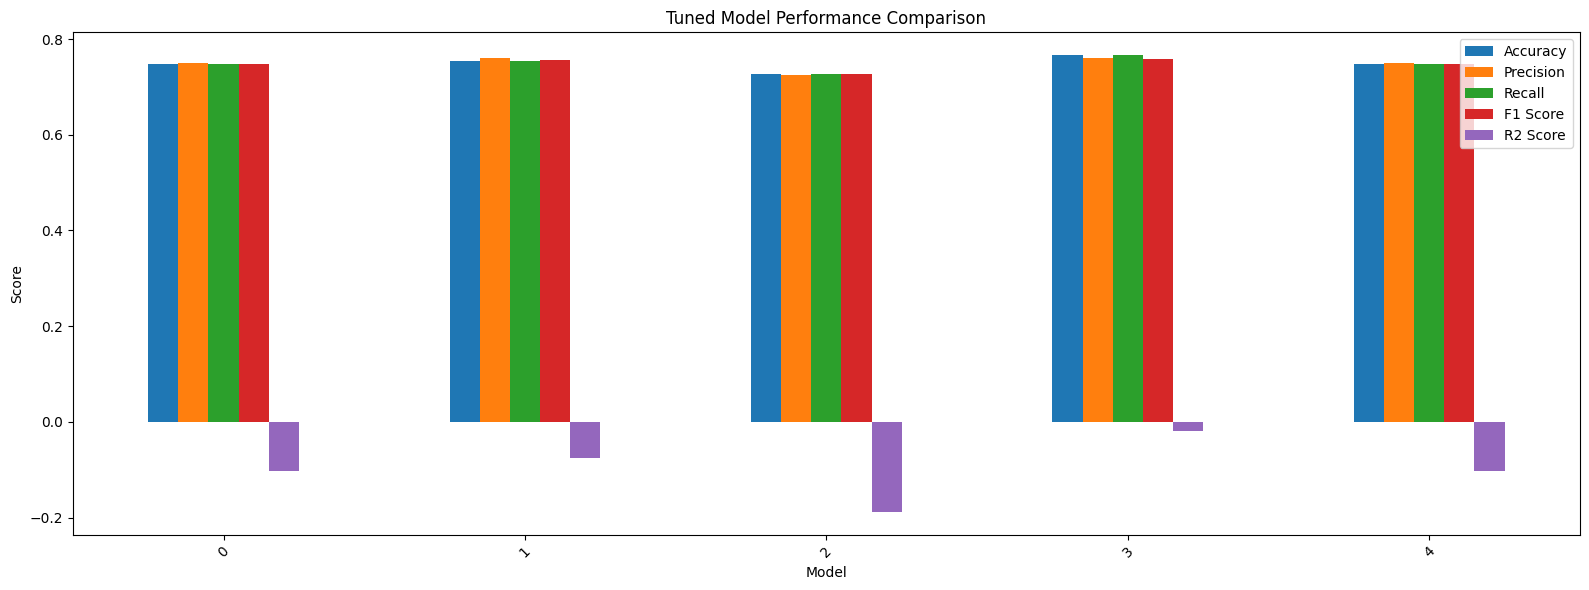

In [95]:
tuned_results_df = tuned_results_df.reset_index()  # Reset index for plotting

# Visualize model performance
plt.figure(figsize=(14, 8))
results_df.plot(kind='bar', figsize=(16, 6))
plt.title('Tuned Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'initial_model_performance.png'))

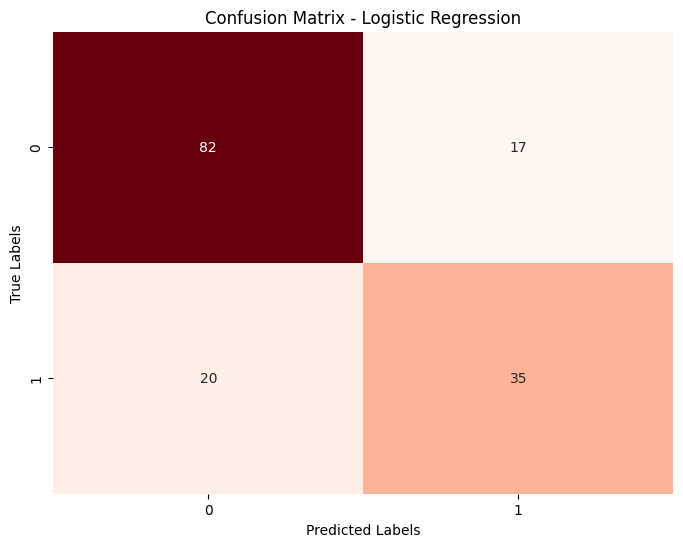

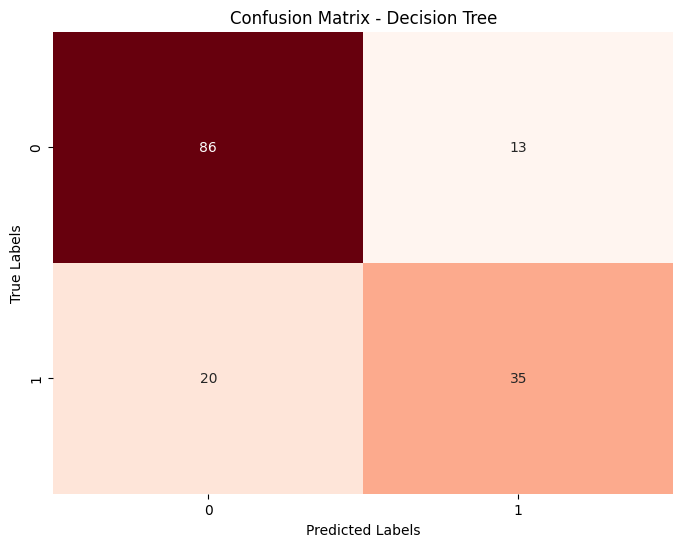

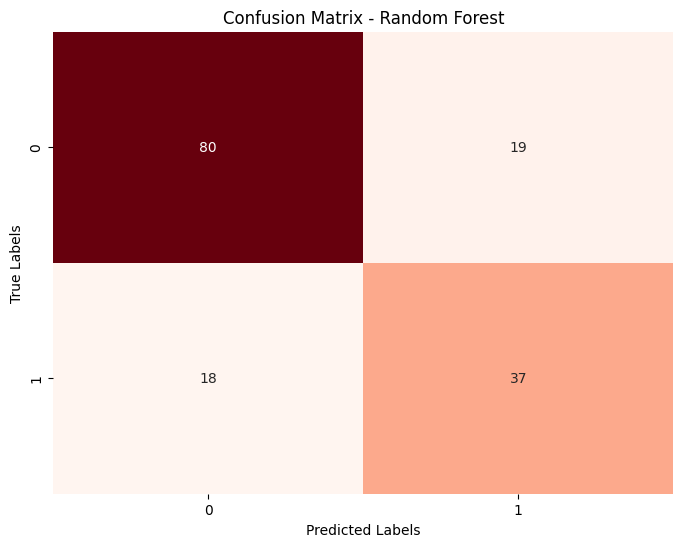

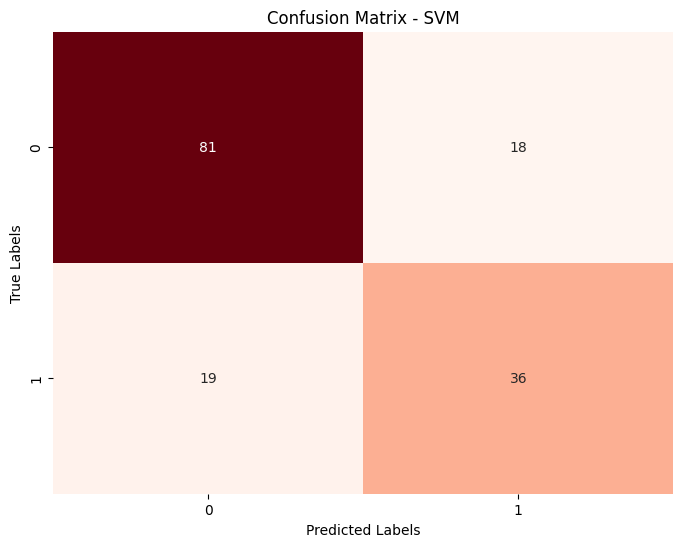

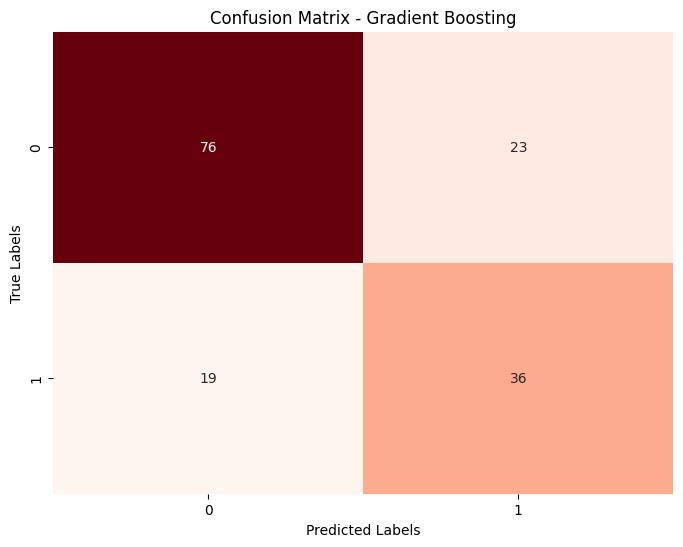

In [97]:
# Save best model
with open(f'models/{name.replace(" ", "_").lower()}_tuned.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save confusion matrices
for name, results in tuned_results.items():
    cm = confusion_matrix(y_test, results['y_pred'])
    np.savetxt(os.path.join(output_dir, f'confusion_matrix_{name.replace(" ", "_").lower()}.csv'), cm, delimiter=',', fmt='%d')

    # Also create and save a visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(os.path.join(output_dir, f'confusion_matrix_{name.replace(" ", "_").lower()}.png'))

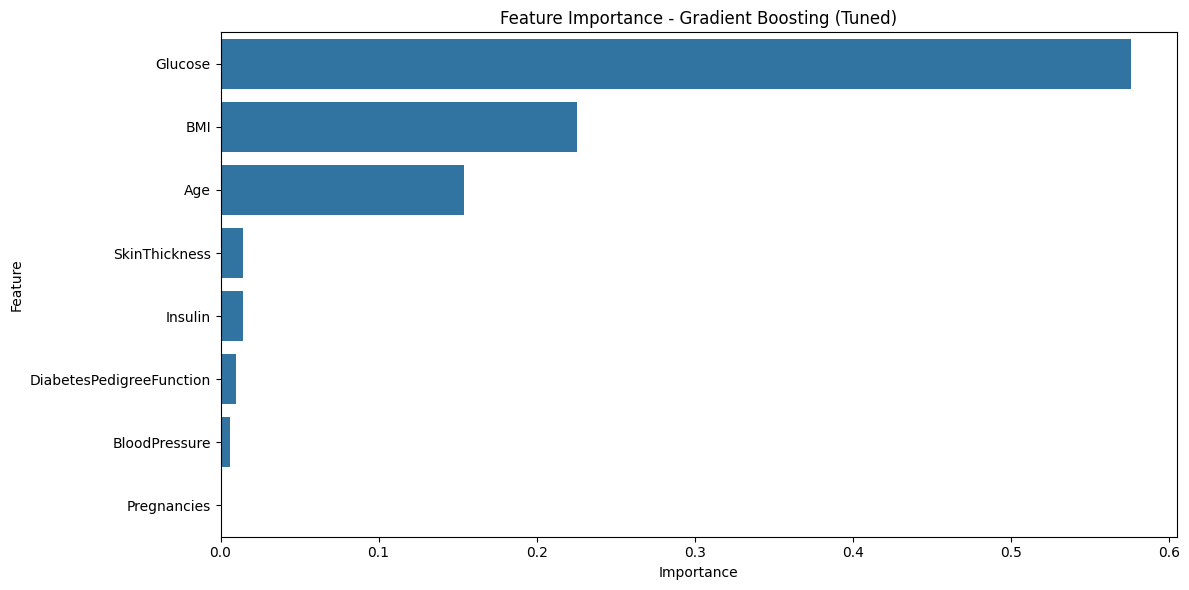

In [98]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importances[name + ' (Tuned)'] = best_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importance - {name} (Tuned)')
    plt.tight_layout()
    plt.show()

# Save tuned results
tuned_results_df = pd.DataFrame(tuned_results)
tuned_results_df.to_csv('results/tuned_results.csv', index=False)

# Save best parameters
best_params_df = pd.DataFrame.from_dict(best_params, orient='index')
best_params_df.to_csv('results/best_parameters.csv')

# Save feature importances
if feature_importances:
    feature_importances_df = pd.DataFrame(feature_importances, index=X.columns)
    feature_importances_df.to_csv('results/feature_importances.csv')

In [82]:
# =============================================
# 5. DASHBOARD CREATION
# =============================================

def create_dashboard(original_results, tuned_results):
    """Create interactive dashboard comparing model performance"""

    # Define metrics here within the function's scope
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'R2 Score']

    # Combine results
    original_results_df = pd.DataFrame(original_results).T.reset_index()
    original_results_df['Type'] = 'Original'
    tuned_results_df = pd.DataFrame(tuned_results).T.reset_index()
    tuned_results_df['Type'] = 'Tuned'
    combined_df = pd.concat([original_results_df, tuned_results_df])

    # Create figures
    fig = make_subplots(
        rows=1, cols=5,  # Updated to 1 row, 5 columns
        subplot_titles=('Accuracy', 'Precision', 'Recall', 'F1 Score', 'R2 Score'),
        specs=[[{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}]]
    )


    positions = [(1,1), (1,2), (1,3), (1,4), (1,5)]  # Updated positions

    for metric, pos in zip(metrics, positions):
        fig.add_trace(
            go.Bar(
                x=combined_df['index'],
                y=combined_df[metric],
                marker_color=combined_df['Type'].map({'Original': 'blue', 'Tuned': 'green'}),
                name=metric,
                legendgroup=metric,
                showlegend=(metric=='Accuracy')
            ),
            row=pos[0], col=pos[1]
        )


    # Update layout (adjust for the removed subplot)
    fig.update_layout(
        title='Model Performance Comparison: Original vs Tuned',
        height=400,  # Adjusted height
        width=1500,
        legend_title='Model Type',
        hovermode='x unified',

    )


    # Show the figure
    fig.show()

    # Print summary
    print("\n=== KEY INSIGHTS ===")
    print(f"Best performing model: {tuned_results_df['Accuracy'].idxmax()}")
    print(f"Accuracy improvement after tuning: {tuned_results_df['Accuracy'].max() - original_results_df['Accuracy'].max():.4f}")
    print("\nTop models after tuning:")
    display(tuned_results_df.sort_values('Accuracy', ascending=False))

# Create the dashboard
create_dashboard(results, tuned_results)


=== KEY INSIGHTS ===
Best performing model: 1
Accuracy improvement after tuning: 0.0195

Top models after tuning:


,index,Accuracy,Precision,Recall,F1 Score,R2 Score,Type
1,Decision Tree,0.785714,0.729167,0.636364,0.679612,0.066667,Tuned
0,Logistic Regression,0.759740,0.673077,0.636364,0.654206,-0.046465,Tuned
2,Random Forest,0.759740,0.660714,0.672727,0.666667,-0.046465,Tuned
3,SVM,0.759740,0.666667,0.654545,0.660550,-0.046465,Tuned
4,Gradient Boosting,0.727273,0.610169,0.654545,0.631579,-0.187879,Tuned
